In [25]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import norm
import scipy
from sklearn import preprocessing as pp

In [26]:
data = pd.read_csv('/Users/Emily/Desktop/ReviewerResponses/delta_delta.csv', index_col=0, header=1)
data = data.iloc[1:]
data.columns = data.columns.str.replace('Unnamed.*', 'Strain')

data.tail()

C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


,bca_high,bca_low,control,difference,test,Strain
0,,,,,,
37,6.849777,3.095476,DMSO,4.988027,Spinosad,PR678
38,-4.802221,-8.857336,DMSO,-6.835087,Thiophene,PR678
39,7.797987,3.811547,DMSO,5.826407,Ursolic acid,PR678
40,-1.120939,-4.845255,DMSO,-2.988930,p-Tolualdehyde,PR678
41,-0.740827,-4.736980,DMSO,-2.724380,α-Phellandrene,PR678


In [27]:
N2dat = pd.read_csv('C:/Users/Emily/Documents/S1/inner3.csv', index_col=0)
N2dat = N2dat.sort_values(by='difference')
comp_ord = list(N2dat['test'].unique())
comp_ord.remove('DMSO')
comp_ord.remove('Safranal')

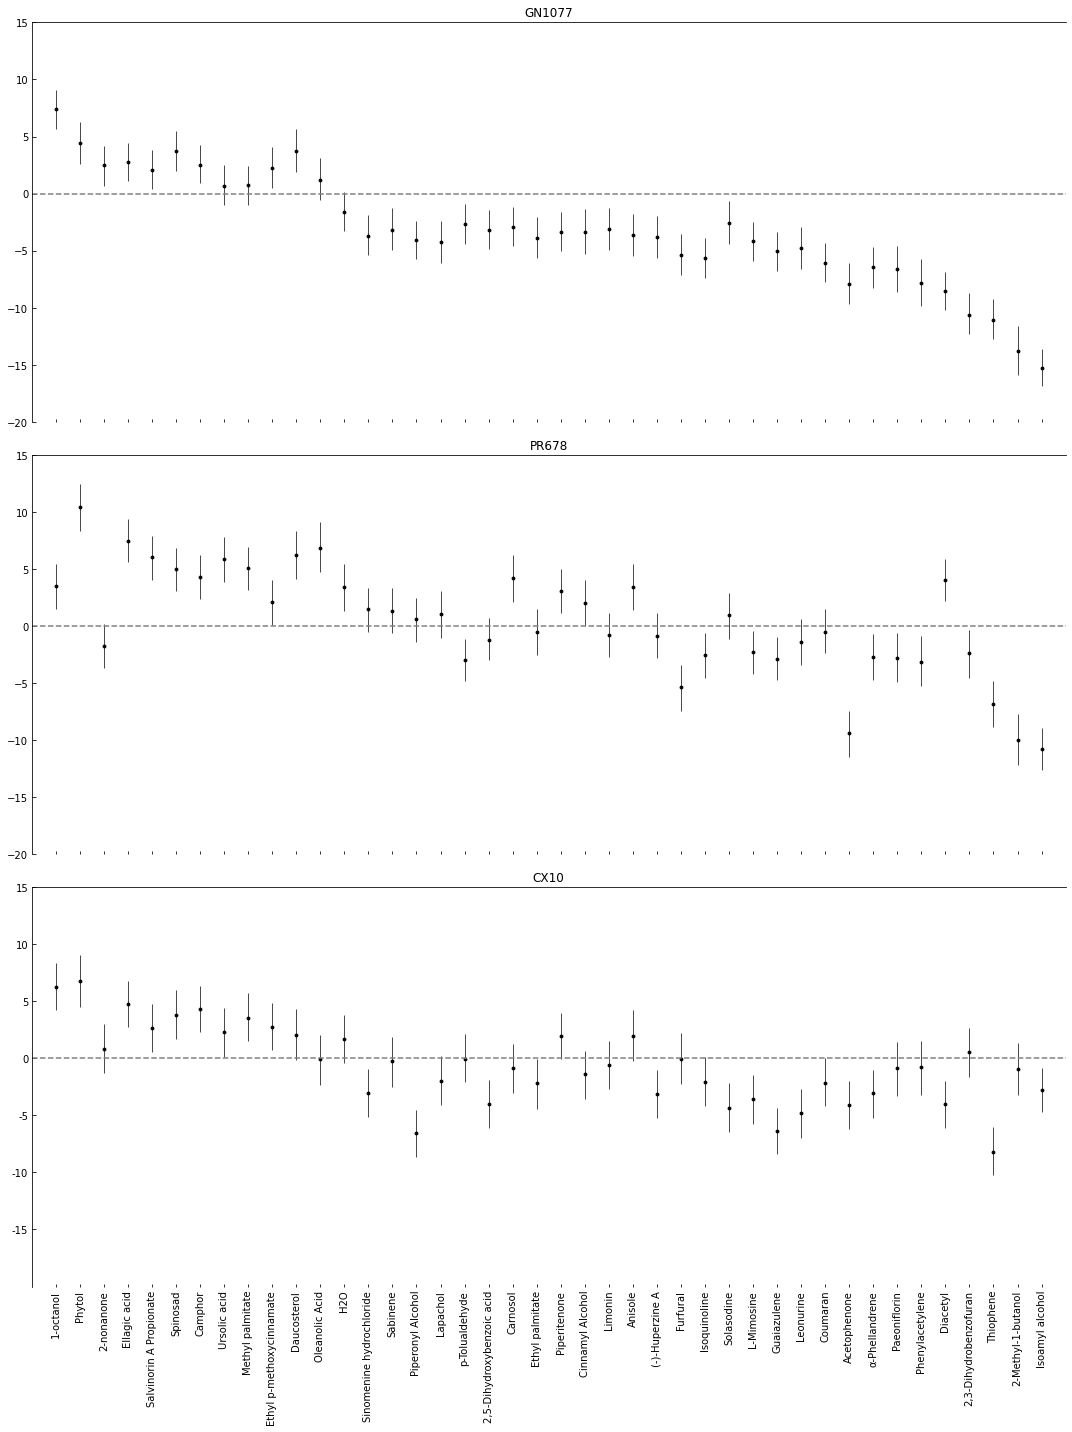

In [47]:
strains = ['GN1077', 'PR678', 'CX10']


fig, ax = plt.subplots(figsize=(15,20), nrows=(len(strains)), sharex=True) 

for s in strains:
    hold = data.loc[data['Strain'] == s]
    reordered = hold.set_index('test')
    reordered = reordered.reindex(comp_ord)
    reordered = reordered.reset_index()
    reordered['bca_low'] = reordered['bca_low'].astype(np.float64)
    reordered['bca_high'] = reordered['bca_high'].astype(np.float64)
    positions = list(range(0, len(comp_ord)))
    
    lines1 = []
    c = strains.index(s)
    
    for index, row in reordered.iterrows():
        

        line = ((index, row['bca_low']), (index, row['bca_high']))
        lines1.append(line)


        #ax.fill_betweenx(positions, plot_data['bca_low'], plot_data['bca_high'], alpha=.25)
    xtick_labels = list(reordered['test'])
    mdiffs1 = list(reordered['difference'])

    hln_coll1 = mpl.collections.LineCollection(lines1, colors='black', linewidths = .7)

    #ax[r,c] = plt.gca()



    y_positions = list(np.arange(-15, 20, 5))

    plt.xticks(positions, xtick_labels )
    plt.yticks(y_positions, y_positions)


    #ax[r,c].xaxis.set_ticks_position('both')
    ax[c].add_collection(hln_coll1)
    ax[c].scatter(positions, mdiffs1, s=8, c='black')
    ax[c].tick_params(axis='both', tickdir='in')
    ax[c].spines['bottom'].set_visible(False)
    ax[c].spines['right'].set_visible(False)

    ax[c].set_ylim(-20, (15))    
    ax[c].set_xlim(-1, len(comp_ord))
    ax[c].set_title(s)
    ax[c].axhline(0, ls='--', c='gray')
    plt.tight_layout()
    plt.rcParams['svg.fonttype'] = 'none'
    plt.xticks(rotation=90)
    #plt.savefig('C:/Users/Emily/Desktop/ReviewerResponses/delta_delta.pdf')


In [29]:
def CItoP(row):
    u = row['bca_high']
    l = row['bca_low']
    Est = row['difference']
    #calculate the standard error from the upper and lower bounds of the confidence interval
    SE = (u-l)/(2*1.96)
    #calculate the z-score from the difference in means (estimated mean) over the standard error
    z = Est/SE
    #find the area under the curve of the CDF for the associated z-score using scipy.stats.special.ndtr or scipy.stats.norm.sf
    #equations to integrate the area under the curve for both functions are the same.
    p = norm.sf(abs(z))*2 #two-sided
    return p

In [30]:
def BH_critical(i, m, Q):
    correction = (i/m)*Q
    return correction

In [31]:
def pranks(df, fdr):
    hed = 'BH_critical_' + str(fdr)
    for index, row in df.iterrows():
        df.loc[index, hed] = BH_critical(row['rank'],42,fdr)
    return df

In [32]:
ps = pd.DataFrame()
for s in strains:
    subs = data.loc[data['Strain']==s]
    for index, row in subs.iterrows():
        subs.loc[index, 'p_value'] = CItoP(row)
    ranked = subs.sort_values(by=['p_value']).reset_index(drop=True)
    ranks=np.arange(1,len(ranked)+1)
    ranked['rank'] = ranks
    BH = pranks(ranked, .05)
    ps = ps.append(BH)


C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\pandas\core\indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [33]:
ps

,bca_high,bca_low,control,difference,test,Strain,p_value,rank,BH_critical_0.05
0,-13.634534,-16.891200,DMSO,-15.318320,Isoamyl alcohol,GN1077,6.458739e-76,1,0.001190
1,-11.620576,-15.917539,DMSO,-13.802287,2-Methyl-1-butanol,GN1077,2.353299e-36,2,0.002381
2,-9.262800,-12.778784,DMSO,-11.082088,Thiophene,GN1077,4.548383e-35,3,0.003571
3,-8.728370,-12.331215,DMSO,-10.619060,"2,3-Dihydrobenzofuran",GN1077,7.059002e-31,4,0.004762
4,-6.903047,-10.196662,DMSO,-8.572018,Diacetyl,GN1077,1.937153e-24,5,0.005952
...,...,...,...,...,...,...,...,...,...
37,2.671095,-1.634511,DMSO,0.541383,"2,3-Dihydrobenzofuran",CX10,6.220850e-01,38,0.045238
38,1.882594,-2.479191,DMSO,-0.265276,Sabinene,CX10,8.115653e-01,39,0.046429
39,2.019656,-2.342389,DMSO,-0.108115,Oleanolic Acid,CX10,9.226000e-01,40,0.047619
40,2.250077,-2.271445,DMSO,-0.097552,Furfural,CX10,9.325998e-01,41,0.048810


In [38]:
filtered_BH = ps.loc[ps['p_value'] < ps['BH_critical_0.05']]
print(len(filtered_BH))


87


In [41]:
filtered_BH.to_csv('/Users/Emily/Desktop/ReviewerResponses/filtered_ddBH.csv')

In [42]:
ps.to_csv('/Users/Emily/Desktop/ReviewerResponses/ddBH.csv')